In [69]:
import torch
import numpy as np
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.utils import dense_to_sparse
from sklearn.metrics.pairwise import haversine_distances
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F
import random
import pandas as pd
import os
import joblib
# device = torch.device(f"cuda:{0}")
device = torch.device("cpu")

seed = 42
random.seed(seed)          # Python random module
np.random.seed(seed)       # Numpy module
torch.manual_seed(seed)    # PyTorch CPU operations

# If you are using CUDA (GPU)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)         # Current GPU
    torch.cuda.manual_seed_all(seed) 


In [70]:
#import model 



model_path = "dreaming_monkey/multispire_generated_data/2025-04-28_11-42-27"
if model_path[-1] != "/":
    model_path = model_path + "/"

#take out the first folder 
model_path = model_path.split("/")[1:]
model_path = "/".join(model_path)


model_name = "pretrained_stgnn.pth"

class STGNN(nn.Module):
     """
     Simple Spatio-Temporal Graph Neural Network using GCN and GRU.
     Predicts `pred_len` steps ahead for all nodes.
     """
     def __init__(self, num_nodes, num_features, seq_len, pred_len,
                    gcn_hidden_dim, gru_hidden_dim, dropout=0.1):
          super().__init__()
          self.num_nodes = num_nodes
          self.num_features = num_features
          self.seq_len = seq_len
          self.pred_len = pred_len
          self.gcn_hidden_dim = gcn_hidden_dim
          self.gru_hidden_dim = gru_hidden_dim

          if GCNConv is None:
               raise ImportError("GCNConv not available. Install torch-geometric.")

          # Spatial Layer
          self.gcn = GCNConv(num_features, gcn_hidden_dim)

          # Temporal Layer
          # Input to GRU will be the spatially processed features
          self.gru = nn.GRU(gcn_hidden_dim, gru_hidden_dim, batch_first=True) # batch_first = True helps

          self.dropout = nn.Dropout(p=dropout)

          # Output Layer: Predicts pred_len steps for each node's feature
          self.output_fc = nn.Linear(gru_hidden_dim, pred_len * num_features)

     def forward(self, x, edge_index, edge_weight=None):
          """
          Forward pass of the STGNN.

          Args:
               x (torch.Tensor): Input tensor of shape (batch_size, num_nodes, seq_len, num_features).
               edge_index (torch.Tensor): Graph edge index, shape (2, num_edges).
               edge_weight (torch.Tensor, optional): Edge weights, shape (num_edges,).

          Returns:
               torch.Tensor: Prediction tensor of shape (batch_size, num_nodes, pred_len).
                              (Assuming num_features=1 for prediction)
          """
          batch_size, _, _, _ = x.shape
          # device = x.device

          # Process sequence step-by-step to apply GCN
          gru_inputs = []
          for t in range(self.seq_len):
               # Get features for all nodes at time step t: shape (batch_size, num_nodes, num_features)
               xt = x[:, :, t, :]

               # Reshape for GCN: (batch_size * num_nodes, num_features)
               xt_reshaped = xt.reshape(-1, self.num_features)

               # Adapt edge_index for batch processing (if not using PyG DataLoader)
               # This replicates the graph structure for each item in the batch
               batch_edge_index = edge_index.repeat(1, batch_size)
               edge_index_offsets = torch.arange(0, batch_size, device=device) * self.num_nodes
               batch_edge_index = batch_edge_index + edge_index_offsets.repeat_interleave(edge_index.shape[1])

               # Adapt edge_weight for batch processing (if provided)
               batch_edge_weight = edge_weight.repeat(batch_size) if edge_weight is not None else None

               # Apply GCN
               gcn_out = self.gcn(xt_reshaped, batch_edge_index, batch_edge_weight)
               gcn_out = F.relu(gcn_out) # Activation after GCN

               # Reshape back: (batch_size, num_nodes, gcn_hidden_dim)
               gcn_out = gcn_out.view(batch_size, self.num_nodes, self.gcn_hidden_dim)
               gru_inputs.append(gcn_out)

          # Stack outputs along the sequence dimension: (batch_size, seq_len, num_nodes, gcn_hidden_dim)
          gru_input_sequence = torch.stack(gru_inputs, dim=1)

          # Flatten nodes dimension for GRU processing
          # GRU expects input: (batch_size * num_nodes, seq_len, input_size)
          gru_input_sequence = gru_input_sequence.permute(0, 2, 1, 3) # -> (batch, node, seq, hidden)
          gru_input_sequence = gru_input_sequence.reshape(batch_size * self.num_nodes, self.seq_len, self.gcn_hidden_dim)

          # Apply GRU
          # Initialize hidden state: (D*num_layers, N, Hout) = (1, batch*nodes, gru_hidden)
          # h0 = torch.zeros(1, batch_size * self.num_nodes, self.gru_hidden_dim).to(device)
          # gru_output shape: (batch*nodes, seq_len, gru_hidden)
          # hidden state shape: (1, batch*nodes, gru_hidden)
          gru_output, hidden = self.gru(gru_input_sequence) # Pass h0=h0 if needed

          # Take the output corresponding to the *last* time step from the GRU sequence output
          # gru_output shape: (batch*nodes, seq_len, gru_hidden) -> select last step
          last_step_output = gru_output[:, -1, :] # Shape: (batch*nodes, gru_hidden)

          # Apply dropout
          last_step_output = self.dropout(last_step_output)

          # Apply Output Layer
          # Input shape: (batch*nodes, gru_hidden)
          # Output shape: (batch*nodes, pred_len * num_features)
          predictions = self.output_fc(last_step_output)

          # Reshape predictions back to (batch_size, num_nodes, pred_len, num_features)
          predictions = predictions.view(batch_size, self.num_nodes, self.pred_len, self.num_features)

          # If predicting only one feature (e.g., car count), squeeze the last dim
          if self.num_features == 1:
               predictions = predictions.squeeze(-1) # -> (batch_size, num_nodes, pred_len)

          return predictions

In [71]:
def create_graph_data(locations, threshold=None, k=None):
    """
    Creates graph connectivity data (edge_index and edge_weight).

    Args:
        locations (np.ndarray): Array of shape (num_spires, 2) with lat/lon.
        threshold (float, optional): Distance threshold for connecting nodes.
        k (int, optional): Number of nearest neighbors to connect (KNN).
                           Use either threshold or k, not both.

    Returns:
        tuple: (edge_index, edge_weight) suitable for PyG layers.
               edge_index: Tensor shape (2, num_edges)
               edge_weight: Tensor shape (num_edges,)
    """
    num_spires = locations.shape[0]
    dist_mx = haversine_distances(locations, locations)

    if threshold is not None:
        adj_matrix = np.where(dist_mx <= threshold, 1, 0)
        # Optional: Weight edges by inverse distance (closer = higher weight)
        # Use a small epsilon to avoid division by zero for self-loops if included
        # weight_matrix = np.exp(-dist_mx**2 / np.std(dist_mx)**2)
        # adj_matrix = adj_matrix * weight_matrix
    elif k is not None:
        adj_matrix = np.zeros((num_spires, num_spires), dtype=np.float32)
        for i in range(num_spires):
            # Get indices of k nearest neighbors (excluding self)
            neighbor_idxs = np.argsort(dist_mx[i, :])[1:k+1]
            adj_matrix[i, neighbor_idxs] = 1
            # Optional: Make symmetric if desired (A or A.T)
            adj_matrix[neighbor_idxs, i] = 1 # Make symmetric
    else:
        raise ValueError("Must provide either distance 'threshold' or 'k' for KNN.")

    # Ensure no self-loops if not desired, or add them explicitly
    np.fill_diagonal(adj_matrix, 0) # No self-loops for standard GCN here
    # Or add self-loops: np.fill_diagonal(adj_matrix, 1)

    # Convert adjacency matrix to edge_index format for PyG
    adj_matrix_torch = torch.tensor(adj_matrix, dtype=torch.float32)
    edge_index, edge_weight = dense_to_sparse(adj_matrix_torch) # edge_weight will be 1.0 where connection exists

    # If you want distance-based weights instead of binary:
    # Find pairs corresponding to edge_index
    # src, dest = edge_index[0].numpy(), edge_index[1].numpy()
    # distances = dist_mx[src, dest]
    # edge_weight = torch.tensor(np.exp(-distances**2 / np.std(dist_mx[dist_mx > 0])**2), dtype=torch.float32)

    print(f"Graph created with {edge_index.shape[1]} edges.")
    return edge_index, edge_weight

In [72]:
#get spires list

spires_list = np.load(model_path + "spires_list.npy", allow_pickle=True)

num_nodes = len(spires_list)

#spire_275_[44.4868525713782, 11.3395889801473].csv

locations = []

#get locations
for spire in spires_list:
    position = spire[:-4].split("_")[2]
    lat, lon = position.split("[")[1].split("]")[0].split(",")
    lat = float(lat)
    lon = float(lon)
    locations.append([lat, lon])

locations = np.array(locations)

model = STGNN(num_nodes=num_nodes, num_features=1, seq_len=1, pred_len=1,
              gcn_hidden_dim=32, gru_hidden_dim=64, dropout=0.0)

# Load the model state
model.load_state_dict(torch.load(model_path + model_name))

edge_index, edge_weight = create_graph_data(locations, threshold=None, k=5)
edge_index = edge_index.to(device)
edge_weight = edge_weight.to(device)


Graph created with 238 edges.


In [113]:
# generate a trajectory of spire traffic

def get_policy_distribution(mu, stddev):
    """
    Create a normal distribution with the given mean and standard deviation.
    """
    # Ensure mu is a 1D tensor
    if mu.dim() > 1:
        mu = mu.squeeze()
    # Create a normal distribution with the specified mean and stddev
    dist = torch.distributions.Normal(mu, stddev)
    return dist

def generate_sequence_sampling(model,initial_sequence,num_steps_to_generate,sampling_stddev=0.0):
    current_sequence = initial_sequence.clone()
    generated_output = []
    for _ in range(num_steps_to_generate):
        mu = model(current_sequence,edge_index,edge_weight)
        if sampling_stddev > 0.0:
            dist = get_policy_distribution(mu, sampling_stddev)
            sampled_value = dist.sample()
        else:
            sampled_value = mu
        # --- Clip generated values to be within reasonable range (e.g., 0-1 if scaled) ---
        # This is important for vehicle counts which cannot be negative.
        # Adjust clipping range if scaler is different or counts are large.
        sampled_value = torch.clamp(sampled_value, 0.0, 1.5) # Clip to [0, 1.5] (allowing slight overshoot)
        # ---------------------------------------------------------------------------
        #add a dimension to the sampled value
        sampled_value = sampled_value.reshape(sampled_value.shape[0], sampled_value.shape[1], 1)
        generated_output.append(sampled_value)

        next_step_reshaped = sampled_value.unsqueeze(dim=2) # Reshape to (batch_size, num_nodes, 1, num_features)

        current_sequence = torch.cat([current_sequence[:, :, 1:,:], next_step_reshaped], dim=2)

    return torch.cat(generated_output, dim=2)


In [78]:
# initial_sequence = torch.zeros((1, len(spires_list),24,1), dtype=torch.float32) # Initial sequence of zeros
#get initial sequence from data
folder_path_spires = "./sensor_data/"

data_spires = []
locations_spires = []
for spire in spires_list:
    df = pd.read_csv(os.path.join(folder_path_spires, spire))
    data_spires.append(df.values)
    coordinates = spire.split("_")[2].split("[")[1].split("]")[0].split(",")

    lat = float(coordinates[0])
    lon = float(coordinates[1])
    locations_spires.append([lat, lon])

total_timesteps = df.shape[0] # Assuming all spires have the same number of timesteps

#transform the data to a numpy array
locations = np.array(locations_spires)
raw_data = np.array(data_spires)

#load scaler
scaler = joblib.load(model_path + "minmax_scaler.joblib")

#transform the data
raw_data = scaler.transform(raw_data.reshape(-1, 1)).reshape(len(spires_list), total_timesteps, 1)


num_steps_to_generate = 24 # Number of steps to generate

#take a random initial_sequence from the data
# random_index = random.randint(0, total_timesteps - int(2*num_steps_to_generate))
random_index = int(24*10)
initial_sequence = raw_data[:, random_index:random_index + num_steps_to_generate, :].reshape(1, len(spires_list), num_steps_to_generate, 1)
initial_sequence = torch.tensor(initial_sequence, dtype=torch.float32).to(device)

expected_sequence = raw_data[:, random_index+ num_steps_to_generate:random_index + int(2*num_steps_to_generate), :]

sampling_stddev = 0.0  # Standard deviation for sampling (0.0 for deterministic output)
generated_sequence = generate_sequence_sampling(model, initial_sequence, num_steps_to_generate, sampling_stddev)

#transform to original scale

generated_sequence = generated_sequence.cpu().detach().numpy()
generated_sequence = scaler.inverse_transform(generated_sequence.reshape(-1, 1)).reshape(1, len(spires_list), num_steps_to_generate)
expected_sequence = expected_sequence.reshape(1, len(spires_list), num_steps_to_generate)
expected_sequence = scaler.inverse_transform(expected_sequence.reshape(-1, 1)).reshape(1, len(spires_list), num_steps_to_generate)
#show shape
print("Generated sequence shape:", generated_sequence.shape)
print("Expected sequence shape:", expected_sequence.shape)

Generated sequence shape: (1, 38, 24)
Expected sequence shape: (1, 38, 24)


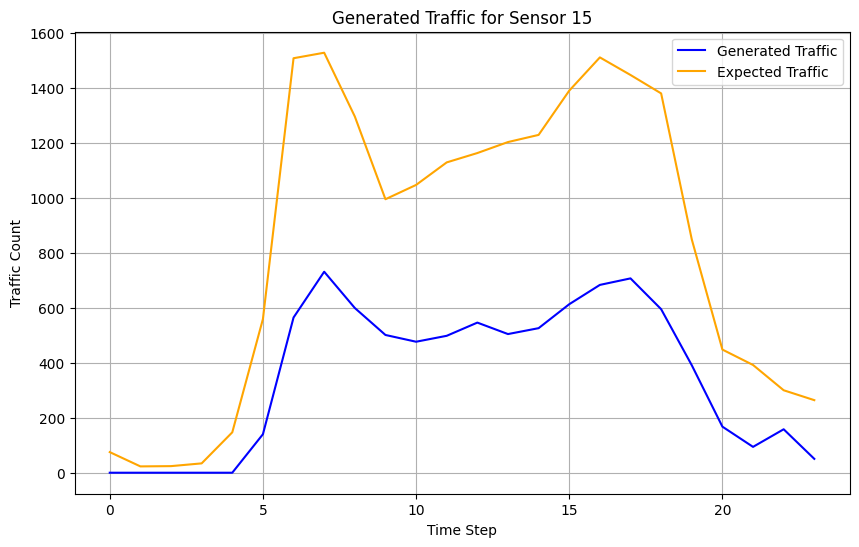

In [85]:
#show first sensor output in a plot

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

sensor_index = 15

# Plot the generated sequence for the first sensor
ax.plot(generated_sequence[0, sensor_index, :], label='Generated Traffic', color='blue')
# Plot the expected sequence for the first sensor
ax.plot(expected_sequence[0,sensor_index,:], label='Expected Traffic', color='orange')
# Plot settings

ax.set_title(f'Generated Traffic for Sensor {sensor_index}')
ax.set_xlabel('Time Step')
ax.set_ylabel('Traffic Count')
ax.legend()
plt.grid()
plt.show()




In [117]:
#model evaluation on daily generations obtaining the mean error

folder_path_spires = "./sensor_data/"

data_spires = []
locations_spires = []
for spire in spires_list:
    df = pd.read_csv(os.path.join(folder_path_spires, spire))
    data_spires.append(df.values)
    coordinates = spire.split("_")[2].split("[")[1].split("]")[0].split(",")

    lat = float(coordinates[0])
    lon = float(coordinates[1])
    locations_spires.append([lat, lon])

total_timesteps = df.shape[0] # Assuming all spires have the same number of timesteps

#transform the data to a numpy array
locations = np.array(locations_spires)
raw_data = np.array(data_spires)

#load scaler
scaler = joblib.load(model_path + "minmax_scaler.joblib")

#transform the data
raw_data = scaler.transform(raw_data.reshape(-1, 1)).reshape(len(spires_list), total_timesteps, 1)


num_steps_to_generate = 24 # Number of steps to generate
num_initial_sequences = 100 # Number of initial sequences to generate



errors = []

#create list of initial sequences without replacement
initial_sequences_index = np.random.choice(total_timesteps - int(2*num_steps_to_generate), num_initial_sequences, replace=False)

#create batch of initial sequences
initial_sequences = []
expected_sequences = []

for initial_sequence_index in initial_sequences_index:
    #take a random initial_sequence from the data

    initial_sequence = raw_data[:, initial_sequence_index:initial_sequence_index + num_steps_to_generate, :].reshape(1, len(spires_list), num_steps_to_generate, 1)
    initial_sequence = torch.tensor(initial_sequence, dtype=torch.float32).to(device)
    expected_sequence = raw_data[:, initial_sequence_index+ num_steps_to_generate:initial_sequence_index + int(2*num_steps_to_generate), :].reshape(1, len(spires_list), num_steps_to_generate, 1)
    expected_sequence = torch.tensor(expected_sequence, dtype=torch.float32).to(device)

    initial_sequences.append(initial_sequence)
    expected_sequences.append(expected_sequence)
    
initial_sequences = torch.cat(initial_sequences, dim=0)
initial_sequences = initial_sequences.to(device)
expected_sequences = torch.cat(expected_sequences, dim=0)
expected_sequences = expected_sequences.to(device)


sampling_stddev = 0.0  # Standard deviation for sampling (0.0 for deterministic output)
generated_sequence = generate_sequence_sampling(model, initial_sequences, num_steps_to_generate, sampling_stddev)

#transform to original scale

generated_sequence = generated_sequence.cpu().detach().numpy()
generated_sequence = scaler.inverse_transform(generated_sequence.reshape(-1, 1)).reshape(num_initial_sequences, len(spires_list), num_steps_to_generate,1)
expected_sequence = expected_sequences.cpu().detach().numpy()
expected_sequence = scaler.inverse_transform(expected_sequence.reshape(-1, 1)).reshape(num_initial_sequences, len(spires_list), num_steps_to_generate,1)

#calculate mean error
mean_error = np.mean(np.abs(generated_sequence - expected_sequence))
print("Mean error:", mean_error)


Mean error: 137.13252
